<a href="https://colab.research.google.com/github/jacobmrCuzzins/Machine-DeepLearning-/blob/main/Evolutionary_Algorithms_Image_Classification_Jacob_Cousins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizing an Evolutionary Algorithm (EA) to optimize the structure of the MLP for classifying images in the CIFAR-10 dataset.




## Accessing Data from Google Drive
The dataset for this notebook is the CIFAR-10 dataset that can be found here:
https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 and CIFAR-100 are well studied, yet challenging image recognition dataset. The CIFAR-10 has up to 10 classes to classify and contains 60,000 32x32 images. You should read the description of the dataset and download the dataset for Python, that is

CIFAR-10 python version: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

Once downloaded you need to then extract and upload the `cifar-10-batches-py` directory your Google Drive so that you can access it from within your Google Colab.

You can mount the Google Drive from the menu on the left or uncomment use the code below mount the drive.  See here for documentation on file access in Colab:

[External data: Local Files, Drive, Sheets, and Cloud Storage](https://colab.research.google.com/notebooks/io.ipynb)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Functions to work with CIFAR

The functions below help with access to the CIFAR-10 data

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

def load_CIFAR_batch(filename, flatten=True, categorical=True):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        if (flatten):
          X = X.reshape(10000, 3072)
        X = X.astype('float32')
        X /= 255

        y = datadict[b'labels']
        y = np.array(y)
        if (categorical):
          y = pd.get_dummies(y).values

        return X, y

def load_CIFAR_meta(filename):
  with open(filename,'rb') as f:
    metadict = pickle.load(f, encoding='bytes')

    class_labels = [ val.decode() for val in metadict.get(b'label_names') ]
    return class_labels

def get_image(X, index, nchans=3, size=32):
  xi = X[index,:]
  img = xi.reshape(32, 32, 3)
  return img

## Load the CIFAR data

The CIFAR data has 5 batches of data and 1 test data set. Each batch is labelled
- `data_batch_1`
- `data_batch_2`
- `data_batch_3`
- `data_batch_4`
- `data_batch_5`

and a test set labelled
- `test_batch`

each batch has 10,000 images, so 50,000 training and 10,000 test images.

Below is example of loading the first batch of training data labelled as `data_batch_1`.  You will need to update the path to match where you have stored your cifar-10 data.

**Run if you want to load only 1 batch of the data**

In [ ]:
X, y = load_CIFAR_batch('/content/drive/My Drive/cifar-10-batches-py/data_batch_1')

# split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

# Create 1d version for testing accuracy
ytrain_1d = np.argmax(ytrain, axis=1)
ytest_1d = np.argmax(ytest, axis=1)

**Run to load the full dataset**

In [ ]:
 # Initialize empty lists to store data
X_batches = []
y_batches = []

# Load and append data from each batch
for i in range(1, 6):
    filename = '/content/drive/My Drive/cifar-10-batches-py/data_batch_' + str(i)
    X_batch, y_batch = load_CIFAR_batch(filename)
    X_batches.append(X_batch)
    y_batches.append(y_batch)

Xtest, ytest = load_CIFAR_batch('/content/drive/My Drive/cifar-10-batches-py/test_batch')

# Concatenate batches to form X and y
Xtrain = np.concatenate(X_batches, axis=0)
ytrain = np.concatenate(y_batches, axis=0)

class_labels = load_CIFAR_meta('/content/drive/MyDrive/cifar-10-batches-py/batches.meta')

# smaller dataset for faster training
Xtrain_small, ytrain_small = load_CIFAR_batch('/content/drive/My Drive/cifar-10-batches-py/data_batch_1')

# Create 1d version for testing accuracy
ytrain_1d = np.argmax(ytrain, axis=1)
ytest_1d = np.argmax(ytest, axis=1)
ytrain_small_1d = np.argmax(ytrain_small, axis=1)

***NOMALIZE THE DATA USING Z-SCORE STANDARD SCALER***

In [ ]:
# Initialize the StandardScaler I AM USING Z-Score STANDARDIZATION
scaler = StandardScaler()

#transform training data
Xtrain_scaled = scaler.fit_transform(Xtrain)

#transform testing data
Xtest_scaled = scaler.transform(Xtest)

**PCA Application**

Explained Variance Ratios: [2.7010629e-01 1.1418346e-01 7.0529781e-02 ... 3.4142520e-09 3.3523762e-09
 3.2031073e-09]


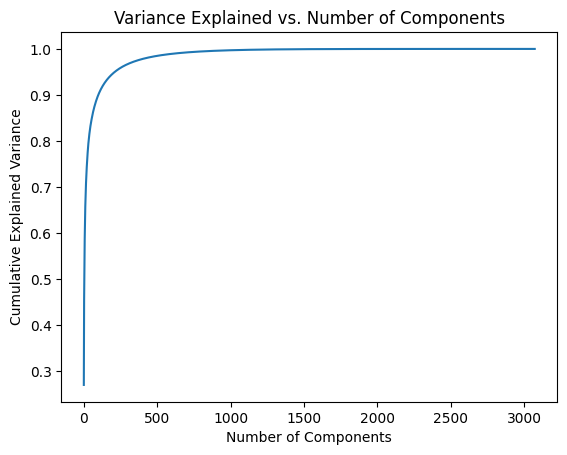

Number of components for 99% explained variance: 618
Number of components for 95% explained variance: 211


In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA with desired number of components
n_components = 3072
pca = PCA(n_components=n_components)

# Apply PCA to scaled data
Xtrain_pca = pca.fit_transform(Xtrain_scaled)
Xtest_pca = pca.transform(Xtest_scaled)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)

import matplotlib.pyplot as plt

cum_explained_variance = np.cumsum(explained_variance)
plt.plot(cum_explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Variance Explained vs. Number of Components")
plt.show()

index_99_percent = np.argmax(cum_explained_variance >= 0.99) #Explained Variance Calculations (VALUES CHANGE ON EACH REFRESH SLIGHTLY!)
index_95_percent = np.argmax(cum_explained_variance >= 0.95)

# Print the number of components for 99% and 95% explained variance
print(f"Number of components for 99% explained variance: {index_99_percent}")
print(f"Number of components for 95% explained variance: {index_95_percent}")

***SET PCA TO DESIRED COMPONENTS***

In [ ]:
n_components = 210 #CHOOSEN to optimaise training times but hold above 95% of explained variance
pca = PCA(n_components=n_components)

# Apply PCA to scaled data
Xtrain_pca = pca.fit_transform(Xtrain_scaled)
Xtest_pca = pca.transform(Xtest_scaled)

***TRAINED THE MLP WITH SIMPLE TRAIN_TEST_SPLIT *************

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

hidden_layer_sizes = 1200
activation_fcn = 'relu'  # {identity, logistic, tanh, relu}, default='relu'
max_iter = 100
tol_ = 0.0001
alpha_ = 1e-06
batchsize = 300

# model initialization
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes), activation=activation_fcn,
                    max_iter=max_iter, tol= tol_, alpha = alpha_, batch_size=batchsize,
                    solver='adam', verbose=1,
                    random_state=None,
                    n_iter_no_change=20)

mlp.fit(Xtrain_pca, ytrain)

# Evaluate performance on validation set
validation_accuracy = mlp.score(Xtest_pca, ytest)

# Evaluate performance on training set
training_accuracy = mlp.score(Xtrain_pca, ytrain)
#Evaluation of MLP
ytrue = np.argmax(ytest, axis=1)

#prediction prob
ypreda = mlp.predict_proba(Xtest_pca)

#prediction labels
ypred = np.argmax(ypreda, axis=1)

#classification report
report = classification_report(ytrue, ypred)

#confusion matrix
mat = confusion_matrix(ytrue, ypred)

print(f"Training Accuracy: {training_accuracy}")
print(f"Validation Accuracy: {validation_accuracy}")
print("Classification Report from test set:")
print(report)

print("\nConfusion Matrix:")
print(mat)

Iteration 1, loss = 4.13606150
Iteration 2, loss = 2.41643090
Iteration 3, loss = 2.00061716
Iteration 4, loss = 1.76644695
Iteration 5, loss = 1.58259637
Iteration 6, loss = 1.42913414
Iteration 7, loss = 1.30088009
Iteration 8, loss = 1.18590076
Iteration 9, loss = 1.07756326
Iteration 10, loss = 0.97654342
Iteration 11, loss = 0.88303060
Iteration 12, loss = 0.80330949
Iteration 13, loss = 0.72812733
Iteration 14, loss = 0.66552549
Iteration 15, loss = 0.59792345
Iteration 16, loss = 0.54405803
Iteration 17, loss = 0.49328690
Iteration 18, loss = 0.44959500
Iteration 19, loss = 0.40857028
Iteration 20, loss = 0.36655587
Iteration 21, loss = 0.33569599
Iteration 22, loss = 0.30491596
Iteration 23, loss = 0.27691905
Iteration 24, loss = 0.25548557
Iteration 25, loss = 0.23441376
Iteration 26, loss = 0.21337508
Iteration 27, loss = 0.19526237
Iteration 28, loss = 0.17914492
Iteration 29, loss = 0.16637628
Iteration 30, loss = 0.15326215
Iteration 31, loss = 0.14110941
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 1.0
Validation Accuracy: 0.2704
Classification Report from test set:
              precision    recall  f1-score   support

           0       0.52      0.51      0.51       251
           1       0.53      0.51      0.52       244
           2       0.39      0.40      0.39       258
           3       0.33      0.33      0.33       254
           4       0.34      0.36      0.35       250
           5       0.35      0.32      0.34       234
           6       0.45      0.49      0.47       258
           7       0.49      0.44      0.46       250
           8       0.54      0.61      0.57       256
           9       0.50      0.47      0.48       245

    accuracy                           0.44      2500
   macro avg       0.44      0.44      0.44      2500
weighted avg       0.44      0.44      0.44      2500


Confusion Matrix:
[[127  11  20  10   9   2  13   6  41  12]
 [ 13 124   7  10   9   5  12   7  22  35]
 [ 21   9 103  15  40  20  25  15   6   4]
 [  4

***GRID SEARCH FOR MLP PARAMS***

In [ ]:
from sklearn.model_selection import GridSearchCV
import time
# Record the start time
start_time = time.time()
param_grid = {
    'hidden_layer_sizes': [(100), (300), (600), (1000), 1200, 1500],
    'activation': ['relu'],
    'max_iter': [10, 50, 100, 150],
    'batch_size':[300, 350, 400],
    'tol':[1e5, 1e-2, 1e-4, 1e10],
    'alpha':[1e-5, 5e-6, 2e-6, 1e-6]
}

grid_search = GridSearchCV(MLPClassifier(solver='adam', random_state=None, tol=0.00001, n_iter_no_change=20),
                           param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(Xtrain_pca, ytrain_1d)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Calculate elapsed time
elapsed_time = time.time() - start_time

# Evaluate performance on validation set
validation_accuracy = best_model.score(Xtest_pca, ytest_1d)

# Evaluate performance on training set
training_accuracy = best_model.score(Xtrain_pca, ytrain_1d)

# Evaluation of MLP on test set
ytrue = np.argmax(ytest, axis=1)

# Prediction prob
ypreda = best_model.predict_proba(Xtest_pca)

# Prediction labels
ypred = np.argmax(ypreda, axis=1)

# Classification report
report = classification_report(ytrue, ypred)

# Confusion matrix
mat = confusion_matrix(ytrue, ypred)

print(f"Best Hyperparameters: {best_params}")
#print(f"Training Accuracy: {training_accuracy}")
#print(f"Validation Accuracy: {validation_accuracy}")
print("Classification Report from test set:")
print(report)
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print("\nConfusion Matrix:")
print(mat)

# Evaluate best model on test set
test_accuracy = best_model.score(Xtest_pca, ytest_1d)
print(f"Best score: {test_accuracy}")


Fitting 3 folds for each of 960 candidates, totalling 2880 fits
Best Hyperparameters: {'activation': 'relu', 'alpha': 1e-06, 'batch_size': 300, 'hidden_layer_sizes': 1200, 'max_iter': 100, 'tol': 0.0001}
Classification Report from test set:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       251
           1       0.55      0.51      0.53       244
           2       0.36      0.38      0.37       258
           3       0.28      0.27      0.27       254
           4       0.37      0.37      0.37       250
           5       0.35      0.35      0.35       234
           6       0.46      0.51      0.49       258
           7       0.54      0.50      0.52       250
           8       0.57      0.59      0.58       256
           9       0.50      0.49      0.49       245

    accuracy                           0.45      2500
   macro avg       0.45      0.45      0.45      2500
weighted avg       0.45      0.45      0.45      2500



**INTRODUCING EVOLUTIONARY ALORITHYM to the MLP**

In [ ]:
!pip install deap
!pip install sklearn-genetic-opt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
import deap
import sklearn_genetic
from deap import base, creator, tools, algorithms
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score

***EVOLUTIONARY ALGORITHM SETUP***

In [ ]:
import time
# Record the start time
start_time = time.time()
# Your existing code
param_grid = {'activation': Categorical(['relu']),
              'hidden_layer_sizes': Integer(100,1500,distribution='uniform'),
              'max_iter': Integer(10, 150),
              'batch_size': Integer(300, 350),
              'tol': Continuous(1e-2, 1e10, distribution='log-uniform'),
              'alpha': Continuous(1e-5, 2e-5)
             }
clf = MLPClassifier()

cv = StratifiedKFold(n_splits=3, shuffle=True)

evolved_estimator = GASearchCV(estimator=clf,
                              cv=cv,
                              scoring='accuracy',
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=True,
                              population_size=10,
                              generations=20)
evolved_estimator.fit(Xtrain_pca, ytrain_1d)

# Calculate elapsed time
elapsed_time = time.time() - start_time

# Print the result and elapsed time
print(f"Best score: {evolved_estimator.best_score_}")
print(f"Best parameters: {evolved_estimator.best_params_}")
print(f"Elapsed time: {elapsed_time:.2f} seconds")


gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	10    	0.40628	0.00803558 	0.419733   	0.394267   
1  	20    	0.414613	0.0054943  	0.4224     	0.4032     
2  	20    	0.421347	0.00270404 	0.425333   	0.414267   
3  	20    	0.424013	0.00285498 	0.43       	0.4188     
4  	20    	0.423613	0.00308254 	0.43       	0.419733   
5  	20    	0.423747	0.00375112 	0.427867   	0.416933   
6  	20    	0.425   	0.00263059 	0.427867   	0.420667   
7  	20    	0.426347	0.00229411 	0.427867   	0.421467   
8  	20    	0.425573	0.00279479 	0.427867   	0.4184     
9  	20    	0.423293	0.0045074  	0.427867   	0.416      
10 	20    	0.424387	0.00254834 	0.427867   	0.420667   
11 	20    	0.4262  	0.00326939 	0.4316     	0.421333   
12 	20    	0.42628 	0.00264286 	0.4316     	0.4216     
13 	20    	0.42312 	0.00494025 	0.434      	0.417333   
14 	20    	0.42476 	0.00388458 	0.434      	0.4204     
15 	20    	0.424693	0.00270624 	0.428      	0.42       
16 	20    	0.425067	0.00226745 	0.428      	0.42  

***PRINT BEST FOUND PARAMETERS***

In [ ]:
# Best parameters found
print(evolved_estimator.best_params_)
# Use the model fitted with the best parameters
y_predict_ga = evolved_estimator.predict(Xtest_pca)
print(accuracy_score(ytest_1d, y_predict_ga))

{'activation': 'relu', 'hidden_layer_sizes': 1400, 'max_iter': 120, 'batch_size': 304, 'tol': 0.011483076356155218, 'alpha': 1.5988952977785457e-05}
0.4592


*** FITNESS EVOLUTION PLOT***

This code gives a visual representation of the evolution of fitness results over generations

/usr/local/lib/python3.10/dist-packages/sklearn_genetic/plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


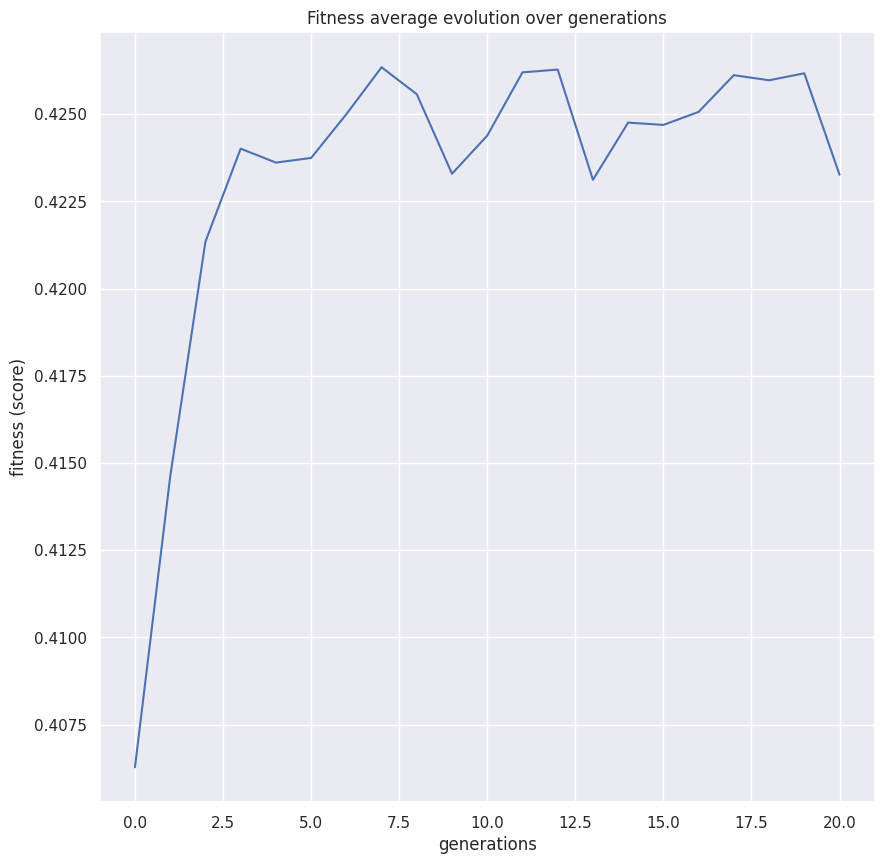

In [ ]:
from sklearn_genetic.plots import plot_fitness_evolution
plot_fitness_evolution(evolved_estimator)
plt.show()

*** HEAT MAP OF HYPERPARAMETER MUTATIONS ***

This code demonstrates a visual representation of the natural selection process made displaying values where the most mutations happened around selecting optimal values

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/usr

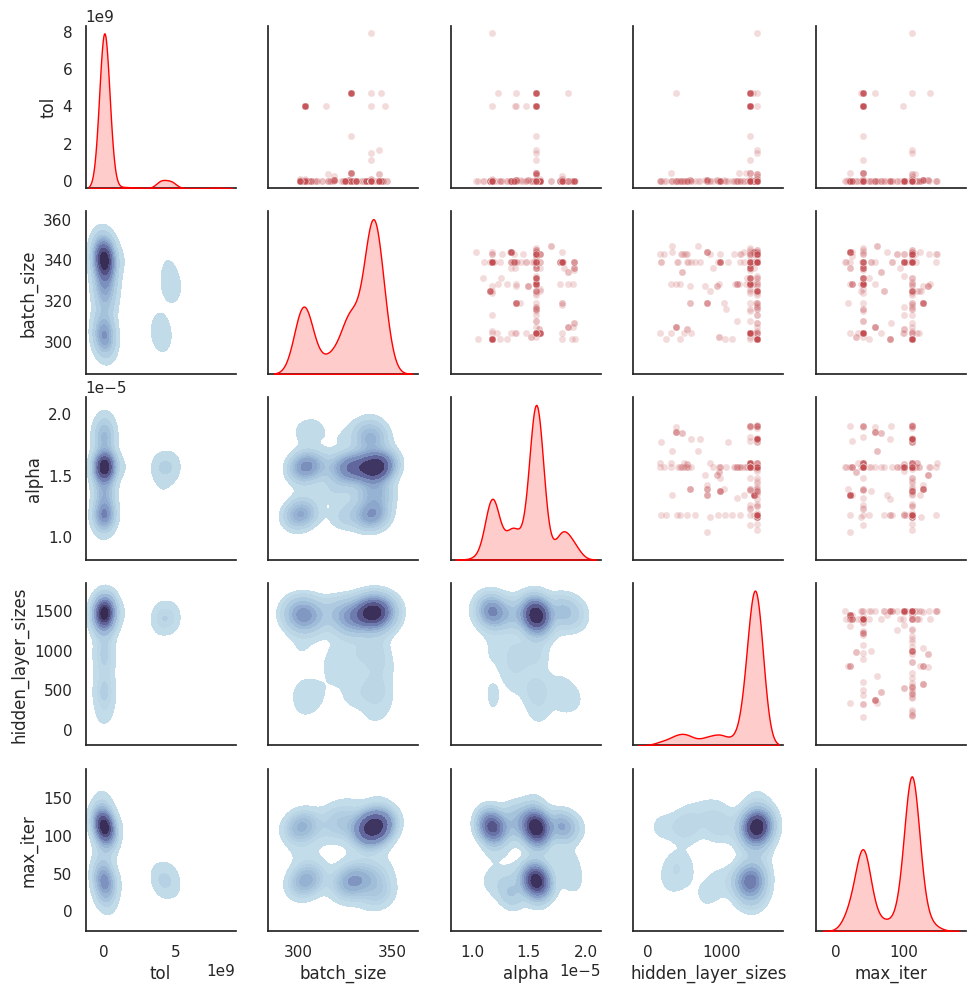

In [ ]:
from sklearn_genetic.plots import plot_search_space
plot_search_space(evolved_estimator, features=['tol', 'batch_size', 'alpha','hidden_layer_sizes','max_iter'])
plt.show()

***EVALUATION METHODS***

***SIMPLE TRAIN-TEST-SPLIT*** Simple train test split printing out classification report for accuracy.  Data is already split into train and test data at the top of the notebook.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

hidden_layer_sizes = 1200
activation_fcn = 'relu'  # {identity, logistic, tanh, relu}, default='relu'
max_iter = 100
tol_ = 0.0001
alpha_ = 1e-06
batchsize = 300

# model initialization
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes), activation=activation_fcn,
                    max_iter=max_iter, tol= tol_, alpha = alpha_, batch_size=batchsize,
                    solver='adam', verbose=1,
                    random_state=None,
                    n_iter_no_change=20)

mlp.fit(Xtrain_pca, ytrain_1d)

# Evaluate performance on validation set
validation_accuracy = mlp.score(Xtest_pca, ytest_1d)

# Evaluate performance on training set
training_accuracy = mlp.score(Xtrain_pca, ytrain_1d)
#Evaluation of MLP
ytrue = np.argmax(ytest, axis=1)

#prediction prob
ypreda = mlp.predict_proba(Xtest_pca)

#prediction labels
ypred = np.argmax(ypreda, axis=1)

#classification report
report = classification_report(ytrue, ypred)

#confusion matrix
mat = confusion_matrix(ytrue, ypred)

print(f"Training Accuracy: {training_accuracy}")
print(f"Validation Accuracy: {validation_accuracy}")
print("Classification Report from test set:")
print(report)

print("\nConfusion Matrix:")
print(mat)

Iteration 1, loss = 2.21827898
Iteration 2, loss = 1.36107985
Iteration 3, loss = 1.08392825
Iteration 4, loss = 0.88924288
Iteration 5, loss = 0.74018399
Iteration 6, loss = 0.62643784
Iteration 7, loss = 0.52348762
Iteration 8, loss = 0.43589053
Iteration 9, loss = 0.36403072
Iteration 10, loss = 0.30736444
Iteration 11, loss = 0.25638869
Iteration 12, loss = 0.21260232
Iteration 13, loss = 0.18141724
Iteration 14, loss = 0.15418941
Iteration 15, loss = 0.13014579
Iteration 16, loss = 0.11164646
Iteration 17, loss = 0.09744989
Iteration 18, loss = 0.08380303
Iteration 19, loss = 0.07271267
Iteration 20, loss = 0.06387403
Iteration 21, loss = 0.05641782
Iteration 22, loss = 0.04976937
Iteration 23, loss = 0.04487161
Iteration 24, loss = 0.04063716
Iteration 25, loss = 0.03689987
Iteration 26, loss = 0.03364951
Iteration 27, loss = 0.03075094
Iteration 28, loss = 0.02824468
Iteration 29, loss = 0.02596414
Iteration 30, loss = 0.02400499
Iteration 31, loss = 0.02214777
Iteration 32, los

***10x STRATEFIED K FOLD***

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Initialize StratifiedKFold
num_splits = 10  # Adjust the number of splits as needed
skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

hidden_layer_sizes = 1400
activation_fcn = 'relu'
max_iter = 120
tol_ = 0.011483
alpha_ = 1.598895
batchsize = 304

# model initialization
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes), activation=activation_fcn,
                    max_iter=max_iter, tol= tol_, alpha = alpha_, batch_size=batchsize,
                    solver='adam', verbose=1,
                    random_state=None,
                    n_iter_no_change=20)

# Initialize a list to store the cross-validation scores
cv_scores = []

# Iterate over the splits
for train_index, val_index in skf.split(Xtrain_pca, ytrain_1d):
    X_train, X_val = Xtrain[train_index], Xtrain[val_index]
    y_train, y_val = ytrain_1d[train_index], ytrain_1d[val_index]

    # Train the MLP on the training data
    mlp.fit(X_train, y_train)

    # Evaluate the model on the validation data
    y_val_pred = mlp.predict(X_val)

    # Calculate accuracy and append to cv_scores
    accuracy = accuracy_score(y_val, y_val_pred)
    cv_scores.append(accuracy)

# Calculate the average cross-validation score
average_score = sum(cv_scores) / len(cv_scores)

# Print the cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Average score: {average_score}")


Iteration 1, loss = 9.00604357
Iteration 2, loss = 5.50414890
Iteration 3, loss = 4.66271060
Iteration 4, loss = 4.11700609
Iteration 5, loss = 3.69988400
Iteration 6, loss = 3.37405376
Iteration 7, loss = 3.11917445
Iteration 8, loss = 2.90881857
Iteration 9, loss = 2.74888970
Iteration 10, loss = 2.60336810
Iteration 11, loss = 2.47176114
Iteration 12, loss = 2.35077334
Iteration 13, loss = 2.27022929
Iteration 14, loss = 2.20097472
Iteration 15, loss = 2.12160935
Iteration 16, loss = 2.07696718
Iteration 17, loss = 2.02447295
Iteration 18, loss = 1.95742621
Iteration 19, loss = 1.95187911
Iteration 20, loss = 1.90420852
Iteration 21, loss = 1.87811516
Iteration 22, loss = 1.84583826
Iteration 23, loss = 1.83990287
Iteration 24, loss = 1.84742126
Iteration 25, loss = 1.83371922
Iteration 26, loss = 1.76953503
Iteration 27, loss = 1.75527447
Iteration 28, loss = 1.76772730
Iteration 29, loss = 1.73155547
Iteration 30, loss = 1.73509324
Iteration 31, loss = 1.74005159
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 9.24228889
Iteration 2, loss = 5.42943708
Iteration 3, loss = 4.67034680
Iteration 4, loss = 4.19586854
Iteration 5, loss = 3.82555269
Iteration 6, loss = 3.53170772
Iteration 7, loss = 3.29496518
Iteration 8, loss = 3.09042713
Iteration 9, loss = 2.90038138
Iteration 10, loss = 2.72935211
Iteration 11, loss = 2.59881530
Iteration 12, loss = 2.46206403
Iteration 13, loss = 2.36456130
Iteration 14, loss = 2.27220016
Iteration 15, loss = 2.19702719
Iteration 16, loss = 2.12173982
Iteration 17, loss = 2.04887590
Iteration 18, loss = 2.01605810
Iteration 19, loss = 1.94604727
Iteration 20, loss = 1.92675060
Iteration 21, loss = 1.90308199
Iteration 22, loss = 1.87206695
Iteration 23, loss = 1.83891974
Iteration 24, loss = 1.85172014
Iteration 25, loss = 1.84082071
Iteration 26, loss = 1.79927915
Iteration 27, loss = 1.76997881
Iteration 28, loss = 1.79615737
Iteration 29, loss = 1.77217999
Iteration 30, loss = 1.74345357
Iteration 31, loss = 1.74737239
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 8.66739201
Iteration 2, loss = 5.27499880
Iteration 3, loss = 4.45039146
Iteration 4, loss = 3.95813712
Iteration 5, loss = 3.58709743
Iteration 6, loss = 3.32696246
Iteration 7, loss = 3.07354403
Iteration 8, loss = 2.88584426
Iteration 9, loss = 2.71547836
Iteration 10, loss = 2.57816673
Iteration 11, loss = 2.45009217
Iteration 12, loss = 2.34182317
Iteration 13, loss = 2.24896282
Iteration 14, loss = 2.19173131
Iteration 15, loss = 2.12934427
Iteration 16, loss = 2.07134296
Iteration 17, loss = 2.00531193
Iteration 18, loss = 1.96375204
Iteration 19, loss = 1.92514899
Iteration 20, loss = 1.87589207
Iteration 21, loss = 1.86475381
Iteration 22, loss = 1.83460662
Iteration 23, loss = 1.80930580
Iteration 24, loss = 1.80011905
Iteration 25, loss = 1.76899770
Iteration 26, loss = 1.77698173
Iteration 27, loss = 1.76536855
Iteration 28, loss = 1.75213929
Iteration 29, loss = 1.76507688
Iteration 30, loss = 1.73144461
Iteration 31, loss = 1.71654682
Iteration 32, los

*** 5X5 CROSS VALIDATION ***


In [ ]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

n_outer =  5
n_splits = 5
acc_outer_MLP = []
f1_outer_MLP  = []
mcc_outer_MLP  = []

hidden_layer_sizes = 1200
activation_fcn = 'relu'
max_iter = 100
tol_ = 0.0001
alpha_ = 1e-06
batchsize = 300


for i_outer in range(0,n_outer):

  print('#### Outer Iteration {} of {}'.format(i_outer+1,n_outer))

  # shuffle the dataset every time we do the 5 CV (we really want to be random)
  X_shuf, y_shuf = shuffle(Xtrain_pca, ytrain_1d)

  # create a pipeline classifier model based on the best parameters (USE BEST PARAMS FROM GRID SEARCH and EVOLUTIONARY ALGORITHM)
  model = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes), activation=activation_fcn,
                    max_iter=max_iter, tol= tol_, alpha = alpha_, batch_size=batchsize,
                    solver='adam', verbose=1,
                    random_state=None,
                    n_iter_no_change=20)

  # stratification is always a must!
  skf = StratifiedKFold(n_splits=n_splits,shuffle=True) # inner 5

  # cross_val_predict returns the predictions for the folds
  print('***** cross_val_predict')
  y_pred = cross_val_predict(model, X_shuf, y_shuf, cv=skf, verbose=0)

  acc = accuracy_score(y_shuf,y_pred)
  f1 = f1_score(y_shuf,y_pred,average='macro')
  mcc = matthews_corrcoef(y_shuf,y_pred)
  mat = confusion_matrix(y_shuf, y_pred)

  acc_outer_MLP.append(acc)
  f1_outer_MLP.append(f1)
  mcc_outer_MLP.append(mcc)

print('MLP Outer accuracy M = {:.2f}, SD = {:.4f}'.format(np.mean(acc_outer_MLP)*100,np.std(acc_outer_MLP)*100))
print('MLP Outer F1-Score M = {:.3f}, SD = {:.4f}'.format(np.mean(f1_outer_MLP),np.std(f1_outer_MLP)))
print('MLP Outer MCC      M = {:.3f}, SD = {:.4f}'.format(np.mean(mcc_outer_MLP),np.std(mcc_outer_MLP)))


#### Outer Iteration 1 of 5
***** cross_val_predict
Iteration 1, loss = 2.25002092
Iteration 2, loss = 1.37583102
Iteration 3, loss = 1.05854988
Iteration 4, loss = 0.86511719
Iteration 5, loss = 0.71584059
Iteration 6, loss = 0.59609543
Iteration 7, loss = 0.49695256
Iteration 8, loss = 0.41591291
Iteration 9, loss = 0.35286757
Iteration 10, loss = 0.29897623
Iteration 11, loss = 0.24760433
Iteration 12, loss = 0.20680447
Iteration 13, loss = 0.17641449
Iteration 14, loss = 0.15145481
Iteration 15, loss = 0.12823903
Iteration 16, loss = 0.11103779
Iteration 17, loss = 0.09693739
Iteration 18, loss = 0.08499749
Iteration 19, loss = 0.07453786
Iteration 20, loss = 0.06642118
Iteration 21, loss = 0.05836698
Iteration 22, loss = 0.05218430
Iteration 23, loss = 0.04682487
Iteration 24, loss = 0.04240272
Iteration 25, loss = 0.03887461
Iteration 26, loss = 0.03548460
Iteration 27, loss = 0.03254581
Iteration 28, loss = 0.02996220
Iteration 29, loss = 0.02759652
Iteration 30, loss = 0.025625